# Capstone Project - The Battle of the Neighborhoods

![Image of Toronto](https://www.seetorontonow.com/wp-content/uploads/2020/06/Toronto-Skyline-view-from-lake.jpg)

## Table of Contents
- **[1. Introduction](#Introduction)**
- **[2. Business Problem](#Business)**
- **[3. Target Audience](#Target)**
- **[4. Data](#Data)**
- **[5. Methodology](#Methodology)**
    - [5.1 Data Pre-processing & Cleansing](#DataCleansing)
    - [5.2 Visualizing the Neighborhood Data](#VisualizingNeighborhood)
    - [5.3 Obtaining the Venue data](#Venue)
- **[6. Analysis](#Analysis)**
    - [6.1 Analyze the Venues in Neighborhoods](#AnalyzeVenues)
    - [6.2 Analyze the Neighborhoods](#AnalyzeNeighborhoods)
    - [6.3 Cluster the Neighborhoods](#ClusterNeighborhoods)
    - [6.4 Analysis of each Cluster](#ClusterAnalysis)
- **[7. Results and Discussions](#Results)**
- **[8. Conclusion](#Conclusion)**

<a id='Introduction'></a>
## 1. Introduction
Toronto is the capital city of the Canadian province of Ontario. With a recorded population of 2,731,571 in 2016 it is the most populous city in Canada and the fourth most populous city in North America. Toronto is an international centre of business, finance, arts, and culture, and is recognized as one of the most multicultural and cosmopolitan cities in the world.

Toronto encompasses a geographical area formerly administered by many separate municipalities. These municipalities have each developed a distinct history and identity over the years, and their names remain in common use among Torontonians. Throughout the city there exist hundreds of small neighbourhoods and some larger neighbourhoods covering a few square kilometres.

Having such a diverse mix of people and culture, there exists tough competition the restaurant business in Toronto. Therefore it becomes a challenging task for hoteliers to decide the optimal location to start a new restaurant in a specific neighborhood.

<a id='Business'></a>
## 2. Business Problem
This project uses data science methodologies to find an optimal location for starting a new restaurant in Toronto, Canada.
It tries to identify the most suitable neighborhood, by taking into consideration the competitors, cuisine provided by other restaurants etc.

In summary, this project aims at analysing the restaurants and their cuisines in various neighborhoods of Toronto and figure out the best possible neighborhood to start a new restaurant

<a id='Target'></a>
## 3. Target Audience
This project is beneficial to anyone who is planning to start a new restaurant business in Toronto. The project can also benefit already running restaurants to shift to some other cuisine for better prospects

<a id='Data'></a>
## 4. Data
The data requirements for this project are as follows:

- The Neighboroods details of Toronto shall be obtained from Wikipedia: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
- The geographical location data using Geocoder Package: https://cocl.us/Geospatial_data
- All the existing venues in the neighborhood along with their category: obtained using the FourSquare API

<a id='Methodology'></a>
## 5. Methodology
The following Data Science and Machine Learnings are applied:
- Data pre-processing & Cleansing
- Data Vizualization in geographical maps using Folium
- Transform the Categorical data into Numerical Data for performing ML algorithms by using One-hot-encoding and K-Means Clustering
- Determine the optimum number of clusters using Elbow point

<a id='DataCleansing'></a>
### 5.1 Data Pre-processing & Cleansing

In [1]:
# Import the required libraries
import pandas as pd #Library for data analysis
import numpy as np #Library for handling data in vectors
import requests #Library to handle requests

# !pip install beautifulsoup4 #Uncomment this installation if needed
from bs4 import BeautifulSoup #this package is used for web scraping

In [2]:
# Scrape the list of postal codes in Canada, from the Wikipedia page and read the table
wiki_url = " https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(wiki_url).text
soup = BeautifulSoup(source, 'xml')
postalcode_table = soup.find('table')

In [3]:
# Define a dataframe consisting of 3 columns: PostalCode, Borough and Neighborhood
column_names = ['PostalCode' , 'Borough',  'Neighborhood']
df_postalcode = pd.DataFrame(columns = column_names)
df_postalcode

,PostalCode,Borough,Neighborhood


In [4]:
# Iterate through postalcode_table and populate df_postalcode
for tr_cell in postalcode_table.find_all('tr'):
    row_data = []
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data) == 3:
        df_postalcode.loc[len(df_postalcode)] = row_data

df_postalcode.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [5]:
# Removing the rows where Borough is Not Assigned
df1=df_postalcode[df_postalcode['Borough']!='Not assigned']
df1.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [6]:
# Combining the neighbourhoods with same Postalcode
df2 = df1.groupby(['PostalCode','Borough'], sort=False).agg(', '.join)
df2.reset_index(inplace=True)

# Replacing the name of the neighbourhoods which are 'Not assigned' with names of Borough
df2['Neighborhood'] = np.where(df2['Neighborhood'] == 'Not assigned',df2['Borough'], df2['Neighborhood'])

df2.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [7]:
df2.shape

(103, 3)

In [8]:
# Importing the Lat & Long for various neighborhoods in Canada
lat_lon = pd.read_csv('https://cocl.us/Geospatial_data')
lat_lon.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
# Merging the lat_lon dataframe with the PostalCode dataframe
lat_lon.rename(columns = {'Postal Code': 'PostalCode'}, inplace=True)
df_postalcode_latlon = pd.merge(df2, lat_lon, on='PostalCode')
df_postalcode_latlon.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [10]:
# Get all the rows that contain Toronto in their Borough
df_toronto = df_postalcode_latlon[df_postalcode_latlon['Borough'].str.contains('Toronto', regex=False)]
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


<a id='VisualizingNeighborhood'></a>
### 5.2 Visualizing the Neighborhood data

In [11]:
# Importing the required libraries

!conda install -c conda-forge folium=0.5.0 --yes
import folium #Library for plotting maps

import matplotlib.cm as cm
import matplotlib.colors as colors

print("Libraries imported")

Libraries imported


In [12]:
# Define the geographical coordinates of Toronto. Values obtained from www.latlong.net
lat_toronto = 43.651070 #Latitude
lon_toronto = -79.347015 #Longitude
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.65107, -79.347015


In [13]:
# Define color code for each Borough
boroughs = df_toronto['Borough'].unique().tolist()
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color
borough_color

{'Downtown Toronto': '#E3A5E2',
 'East Toronto': '#F542D1',
 'West Toronto': '#F6F25F',
 'Central Toronto': '#0EA0E7'}

In [14]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color= borough_color[borough],
        fill=True,
        fill_color= borough_color[borough],
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

<a id='Venue'></a>
### 5.3 Obtaining the Venue data

In [14]:
# The code was removed by Watson Studio for sharing.

In [15]:
#Function for getting the top 100 venues around a location, within a radius of 500 meters
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


<a id='Analysis'></a>
## 6. Analysis

<a id='AnalyzeVenues'></a>
### 6.1 Analyze the Venues in the Neighborhoods

In [17]:
# Check the count of Venues in each Neighborhood
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,60,60,60,60,60,60
"Brockton, Parkdale Village, Exhibition Place",26,26,26,26,26,26
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",18,18,18,18,18,18
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17
Central Bay Street,64,64,64,64,64,64
Christie,17,17,17,17,17,17
Church and Wellesley,77,77,77,77,77,77
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,34,34,34,34,34,34


In [18]:
# Get the list of unique Venues
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))
print("The Venue Categories are", toronto_venues['Venue Category'].unique())

There are 238 uniques categories.
The Venue Categories are ['Bakery' 'Coffee Shop' 'Distribution Center' 'Spa' 'Restaurant' 'Park'
 'Historic Site' 'Breakfast Spot' 'Gym / Fitness Center' 'Pub'
 'Farmers Market' 'Chocolate Shop' 'Dessert Shop' 'Performing Arts Venue'
 'Theater' 'French Restaurant' 'Mexican Restaurant' 'Café' 'Yoga Studio'
 'Event Space' 'Shoe Store' 'Ice Cream Shop' 'Cosmetics Shop'
 'Electronics Store' 'Bank' 'Beer Store' 'Antique Shop'
 'Portuguese Restaurant' 'Italian Restaurant' 'Creperie' 'Beer Bar'
 'Persian Restaurant' 'Arts & Crafts Store' 'Sushi Restaurant'
 'Hobby Shop' 'Japanese Restaurant' 'Diner' 'Fried Chicken Joint'
 'Smoothie Shop' 'Sandwich Place' 'College Auditorium' 'Gym' 'Bar'
 'College Cafeteria' 'Art Gallery' 'Clothing Store' 'Comic Shop' 'Plaza'
 'Pizza Place' 'Burrito Place' 'Music Venue' 'Burger Joint'
 'Thai Restaurant' 'Movie Theater' 'College Rec Center'
 'Sporting Goods Shop' 'Shopping Mall' 'Ramen Restaurant' 'Bookstore'
 'Gastropub' 'Fast

In [19]:
# Checking for availability of Indian Restaurants in the Venues
"Indian Restaurant" in toronto_venues['Venue Category'].unique()

True

<a id='AnalyzeNeighborhoods'></a>
### 6.2 Analyze the Neighborhoods

In [20]:
# Categorize the Venues using One-hot-encoding method
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(1640, 239)


,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Group the rows by Neighborhood and by taking the Mean of the frequency of occurance of each category
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped.head()

(39, 239)


,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.016667,0.0,0.0,0.000000,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.038462
2,"Business reply mail Processing Centre, South C...",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.058824,0.058824,0.058824,0.117647,0.176471,0.058824,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
4,Central Bay Street,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.015625,0.0,0.0,0.015625,0.0,0.015625


In [22]:
# Pull out only the Indian Restaurants
ind = to_grouped[["Neighborhoods", "Indian Restaurant"]]
ind = ind.rename(columns={"Neighborhoods" : "Neighborhood"})
ind.head()

,Neighborhood,Indian Restaurant
0,Berczy Park,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000
2,"Business reply mail Processing Centre, South C...",0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000
4,Central Bay Street,0.015625


<a id='ClusterNeighborhoods'></a>
### 6.3 Cluster the Neighborhoods

In [23]:
# Clustering will be done using K-Means clustering.
# The number of clusters (K) would be determined using Elbow Point method

#Import the libraries
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
!pip install -U yellowbrick #Yellowbrick is a suite of visual diagnostic tools
from yellowbrick.cluster import KElbowVisualizer

print('Libraries imported')

     |████████████████████████████████| 266kB 8.4MB/s eta 0:00:01
Libraries imported


In [24]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = ind.drop(['Neighborhood'], axis=1)
print(X.shape)

(39, 1)


In [25]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0], dtype=int32)

In [26]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [27]:
scores = [get_inertia(x) for x in range(2, 21)]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/

Text(0, 0.5, 'Error')

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


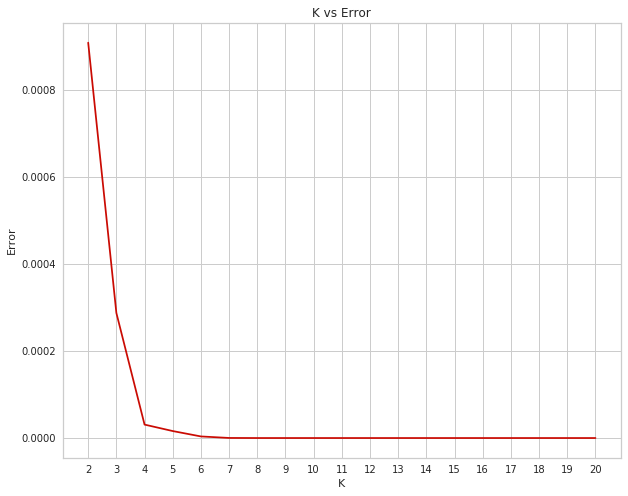

In [28]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

In [29]:
from yellowbrick.cluster import KElbowVisualizer

(39, 1)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/

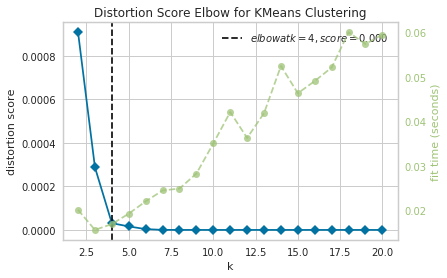

In [30]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,21))
print(X.shape)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

**From the above plot, it is observed that the optimum K value = 4 i.e. there would be 4 Clusters**

In [31]:
kclusters = 4

toronto_grouped_clustering = ind.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 3, 0, 3, 0, 2, 0], dtype=int32)

In [32]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = ind.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

to_merged.head()

,Neighborhood,Indian Restaurant,Cluster Labels
0,Berczy Park,0.000000,0
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0
2,"Business reply mail Processing Centre, South C...",0.000000,0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0
4,Central Bay Street,0.015625,3


In [33]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(1640, 9)


,Neighborhood,Indian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.0,0,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
0,Berczy Park,0.0,0,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
0,Berczy Park,0.0,0,43.644771,-79.373306,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
0,Berczy Park,0.0,0,43.644771,-79.373306,Meridian Hall,43.646292,-79.376022,Concert Hall
0,Berczy Park,0.0,0,43.644771,-79.373306,Goose Island Brewhouse,43.647329,-79.373541,Beer Bar


In [34]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged

(1640, 9)


,Neighborhood,Indian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.000000,0,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
25,"Richmond, Adelaide, King",0.000000,0,43.650571,-79.384568,Friendly Stranger - Cannabis Culture Shop,43.650387,-79.388523,Smoke Shop
25,"Richmond, Adelaide, King",0.000000,0,43.650571,-79.384568,Boxcar Social Temperance,43.650557,-79.381956,Bar
25,"Richmond, Adelaide, King",0.000000,0,43.650571,-79.384568,Assembly Chef's Hall,43.650579,-79.383412,Food Court
25,"Richmond, Adelaide, King",0.000000,0,43.650571,-79.384568,John & Sons Oyster House,43.650656,-79.381613,Seafood Restaurant
25,"Richmond, Adelaide, King",0.000000,0,43.650571,-79.384568,Soho House Toronto,43.648734,-79.386541,Speakeasy
25,"Richmond, Adelaide, King",0.000000,0,43.650571,-79.384568,M Square Coffee Co,43.651218,-79.383555,Coffee Shop
25,"Richmond, Adelaide, King",0.000000,0,43.650571,-79.384568,Ruth's Chris Steak House,43.649917,-79.385724,Steakhouse
25,"Richmond, Adelaide, King",0.000000,0,43.650571,-79.384568,Downtown Toronto,43.653232,-79.385296,Neighborhood
25,"Richmond, Adelaide, King",0.000000,0,43.650571,-79.384568,Cafe Landwer,43.648753,-79.385367,Café


In [35]:
# Check how many Indian Restaurants are there
ircount = to_merged['Venue Category'].value_counts()['Indian Restaurant']
print("There are {} Indian Restaurants in Toronto".format(ircount))

There are 7 Indian Restaurants in Toronto


In [39]:
#Visualize the Indian Restaurants in a map
#create a map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

In [36]:
# How many Neighborhoods per Cluster?
ind["Cluster Labels"] = kmeans.labels_
ind.head()

,Neighborhood,Indian Restaurant,Cluster Labels
0,Berczy Park,0.000000,0
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0
2,"Business reply mail Processing Centre, South C...",0.000000,0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0
4,Central Bay Street,0.015625,3


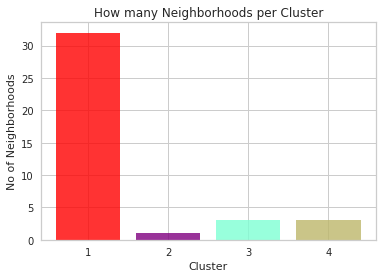

In [37]:
# Plot a bar plot to display Neighborhoods per cluster
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ind['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [38]:
# How many neighborhoods in each cluster
ind['Cluster Labels'].value_counts()

0    32
3     3
2     3
1     1
Name: Cluster Labels, dtype: int64

<a id='ClusterAnalysis'></a>
### 6.4. Analysis of each Cluster

**Cluster 1**

In [39]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df_toronto[['Borough', 'Neighborhood']]
df_new.head()

,Borough,Neighborhood
2,Downtown Toronto,"Regent Park, Harbourfront"
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
9,Downtown Toronto,"Garden District, Ryerson"
15,Downtown Toronto,St. James Town
19,East Toronto,The Beaches


In [40]:
# Red 

cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1

,Borough,Neighborhood,Indian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.654260,-79.360636,GW General,43.650495,-79.357538,Antique Shop
1,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.654260,-79.360636,FUEL+,43.653193,-79.355867,Coffee Shop
2,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.654260,-79.360636,Flame Shack,43.656844,-79.358917,Restaurant
3,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.654260,-79.360636,The Beer Store,43.657773,-79.357463,Beer Store
4,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.654260,-79.360636,Savoury Grounds,43.656821,-79.358970,Coffee Shop
5,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.654260,-79.360636,Vistek,43.657046,-79.359667,Electronics Store
6,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.654260,-79.360636,Rooster Coffee,43.651900,-79.365609,Coffee Shop
7,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.654260,-79.360636,SOMA chocolatemaker,43.650622,-79.358127,Chocolate Shop
8,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.654260,-79.360636,Sumach Espresso,43.658135,-79.359515,Coffee Shop
9,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.654260,-79.360636,Distillery Sunday Market,43.650075,-79.361832,Farmers Market


In [53]:
print('There are {} venues in Cluster 1'.format(len(df_cluster1['Venue'].unique())))

if ("Indian Restaurant" in df_cluster1['Venue Category'].unique()):
    print('There are {} Indian Restaurants in Cluster 1'.format(df_cluster1['Venue Category'].value_counts()['Indian Restaurant']))
else:
    print('There are 0 Indian Restaurants in Cluster 1')

There are 798 venues in Cluster 1
There are 0 Indian Restaurants in Cluster 1


**Cluster 2**

In [54]:
# Purple 
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2.sort_values(["Indian Restaurant"], ascending=False)
df_cluster2

,Borough,Neighborhood,Indian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central Toronto,"The Annex, North Midtown, Yorkville",0.05,1,43.67271,-79.405678,Ezra's Pound,43.675153,-79.405858,Café
1,Central Toronto,"The Annex, North Midtown, Yorkville",0.05,1,43.67271,-79.405678,Subway,43.675650,-79.410255,Sandwich Place
2,Central Toronto,"The Annex, North Midtown, Yorkville",0.05,1,43.67271,-79.405678,Roti Cuisine of India,43.674618,-79.408249,Indian Restaurant
3,Central Toronto,"The Annex, North Midtown, Yorkville",0.05,1,43.67271,-79.405678,Madame Boeuf And Flea,43.675240,-79.406620,Burger Joint
4,Central Toronto,"The Annex, North Midtown, Yorkville",0.05,1,43.67271,-79.405678,Big Crow,43.675896,-79.403680,BBQ Joint
5,Central Toronto,"The Annex, North Midtown, Yorkville",0.05,1,43.67271,-79.405678,Jean Sibelius Square,43.671426,-79.408831,Park
6,Central Toronto,"The Annex, North Midtown, Yorkville",0.05,1,43.67271,-79.405678,Shoppers Drug Mart,43.674959,-79.407986,Pharmacy
7,Central Toronto,"The Annex, North Midtown, Yorkville",0.05,1,43.67271,-79.405678,Tim Hortons,43.675800,-79.403532,Coffee Shop
8,Central Toronto,"The Annex, North Midtown, Yorkville",0.05,1,43.67271,-79.405678,Martino's Pizza,43.675560,-79.403558,Pizza Place
9,Central Toronto,"The Annex, North Midtown, Yorkville",0.05,1,43.67271,-79.405678,Live Organic Food Bar,43.675053,-79.406715,Vegetarian / Vegan Restaurant


In [42]:
df_cluster2.sort_values(["Indian Restaurant"], ascending=False)

,Borough,Neighborhood,Indian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central Toronto,"The Annex, North Midtown, Yorkville",0.05,1,43.67271,-79.405678,Ezra's Pound,43.675153,-79.405858,Café
1,Central Toronto,"The Annex, North Midtown, Yorkville",0.05,1,43.67271,-79.405678,Roti Cuisine of India,43.674618,-79.408249,Indian Restaurant
18,Central Toronto,"The Annex, North Midtown, Yorkville",0.05,1,43.67271,-79.405678,Subway,43.675650,-79.410255,Sandwich Place
17,Central Toronto,"The Annex, North Midtown, Yorkville",0.05,1,43.67271,-79.405678,Tim Hortons,43.675800,-79.403532,Coffee Shop
16,Central Toronto,"The Annex, North Midtown, Yorkville",0.05,1,43.67271,-79.405678,Martino's Pizza,43.675560,-79.403558,Pizza Place
15,Central Toronto,"The Annex, North Midtown, Yorkville",0.05,1,43.67271,-79.405678,LCBO,43.675344,-79.405327,Liquor Store
14,Central Toronto,"The Annex, North Midtown, Yorkville",0.05,1,43.67271,-79.405678,Subway,43.675071,-79.406877,Sandwich Place
13,Central Toronto,"The Annex, North Midtown, Yorkville",0.05,1,43.67271,-79.405678,Haute Coffee,43.675818,-79.402793,Café
12,Central Toronto,"The Annex, North Midtown, Yorkville",0.05,1,43.67271,-79.405678,Pour House,43.675641,-79.403821,Pub
11,Central Toronto,"The Annex, North Midtown, Yorkville",0.05,1,43.67271,-79.405678,The Annex Hodgepodge,43.674975,-79.406543,Sandwich Place


In [43]:
df_cluster2['Venue Category'].value_counts(ascending=False)['Indian Restaurant']

1

In [55]:
print('There are {} venues in Cluster 2'.format(len(df_cluster2['Venue'].unique())))

if ("Indian Restaurant" in df_cluster2['Venue Category'].unique()):
    print('There are {} Indian Restaurants in Cluster 2'.format(df_cluster2['Venue Category'].value_counts()['Indian Restaurant']))
else:
    print('There are 0 Indian Restaurants in Cluster 2')

There are 19 venues in Cluster 2
There are 1 Indian Restaurants in Cluster 2


**Cluster 3**

In [56]:
# Blue
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3

,Borough,Neighborhood,Indian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,East Toronto,"The Danforth West, Riverdale",0.02439,2,43.679557,-79.352188,IL FORNELLO on Danforth,43.678604,-79.346904,Italian Restaurant
1,East Toronto,"The Danforth West, Riverdale",0.02439,2,43.679557,-79.352188,LCBO,43.676816,-79.356047,Liquor Store
2,East Toronto,"The Danforth West, Riverdale",0.02439,2,43.679557,-79.352188,Bar Oak,43.677931,-79.348724,Lounge
3,East Toronto,"The Danforth West, Riverdale",0.02439,2,43.679557,-79.352188,Menchie's,43.678309,-79.348105,Frozen Yogurt Shop
4,East Toronto,"The Danforth West, Riverdale",0.02439,2,43.679557,-79.352188,Factory Girl,43.676693,-79.356299,American Restaurant
5,East Toronto,"The Danforth West, Riverdale",0.02439,2,43.679557,-79.352188,Sher-E-Punjab,43.677308,-79.353066,Indian Restaurant
6,East Toronto,"The Danforth West, Riverdale",0.02439,2,43.679557,-79.352188,Cafe Frappe,43.678126,-79.348434,Coffee Shop
7,East Toronto,"The Danforth West, Riverdale",0.02439,2,43.679557,-79.352188,Second Cup,43.677232,-79.352898,Coffee Shop
8,East Toronto,"The Danforth West, Riverdale",0.02439,2,43.679557,-79.352188,La Diperie,43.677702,-79.352265,Ice Cream Shop
9,East Toronto,"The Danforth West, Riverdale",0.02439,2,43.679557,-79.352188,Dough Bakeshop,43.676643,-79.356846,Bakery


In [57]:
print('There are {} venues in Cluster 3'.format(len(df_cluster3['Venue'].unique())))

if ("Indian Restaurant" in df_cluster3['Venue Category'].unique()):
    print('There are {} Indian Restaurants in Cluster 3'.format(df_cluster3['Venue Category'].value_counts()['Indian Restaurant']))
else:
    print('There are 0 Indian Restaurants in Cluster 3')

There are 106 venues in Cluster 3
There are 3 Indian Restaurants in Cluster 3


**Cluster 4**

In [58]:
# Turquoise
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4

,Borough,Neighborhood,Indian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,Central Bay Street,0.015625,3,43.657952,-79.387383,Jimmy's Coffee,43.658421,-79.385613,Coffee Shop
1,Downtown Toronto,Central Bay Street,0.015625,3,43.657952,-79.387383,Tim Hortons,43.658570,-79.385123,Coffee Shop
2,Downtown Toronto,Central Bay Street,0.015625,3,43.657952,-79.387383,Hailed Coffee,43.658833,-79.383684,Coffee Shop
3,Downtown Toronto,Central Bay Street,0.015625,3,43.657952,-79.387383,Neo Coffee Bar,43.660140,-79.385870,Coffee Shop
4,Downtown Toronto,Central Bay Street,0.015625,3,43.657952,-79.387383,The Queen and Beaver Public House,43.657472,-79.383524,Gastropub
5,Downtown Toronto,Central Bay Street,0.015625,3,43.657952,-79.387383,The Elm Tree Restaurant,43.657397,-79.383761,Modern European Restaurant
6,Downtown Toronto,Central Bay Street,0.015625,3,43.657952,-79.387383,KAKA,43.657457,-79.384192,Japanese Restaurant
7,Downtown Toronto,Central Bay Street,0.015625,3,43.657952,-79.387383,Japango,43.655268,-79.385165,Sushi Restaurant
8,Downtown Toronto,Central Bay Street,0.015625,3,43.657952,-79.387383,Bubble Bath & Spa,43.659050,-79.385344,Spa
9,Downtown Toronto,Central Bay Street,0.015625,3,43.657952,-79.387383,Sansotei Ramen 三草亭,43.655157,-79.386501,Ramen Restaurant


In [59]:
print('There are {} venues in Cluster 4'.format(len(df_cluster4['Venue'].unique())))

if ("Indian Restaurant" in df_cluster4['Venue Category'].unique()):
    print('There are {} Indian Restaurants in Cluster 4'.format(df_cluster4['Venue Category'].value_counts()['Indian Restaurant']))
else:
    print('There are 0 Indian Restaurants in Cluster 4')

There are 219 venues in Cluster 4
There are 3 Indian Restaurants in Cluster 4


**Mean of Clusters**

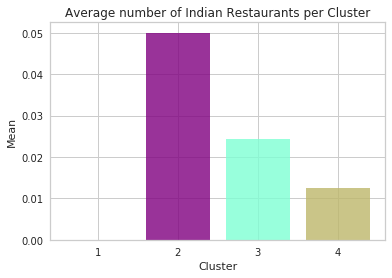

In [46]:
clusters_mean = [df_cluster1['Indian Restaurant'].mean(),df_cluster2['Indian Restaurant'].mean(),df_cluster3['Indian Restaurant'].mean(),
                 df_cluster4['Indian Restaurant'].mean()]
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Indian Restaurants per Cluster')

plt.show()

<a id='Results'></a>
## 7. Results and Discussions
- Most of the Indian Restaurants are in cluster 2 represented by the purple clusters
- The Neighborhoods located in the Central Toronto area that have the highest average of Indian Restaurants are The Annex, North Midtown and Yorkville
- Even though there is a huge amount of Neighborhoods in cluster 1, there is little to no Indian Restaurant
- In the East Toronto area (cluster 3) has the second largest average of Indian Restaurants
- Looking at the nearby venues, the optimum place to put a new Indian Restaurant is in Downtown Toronto as there are many Neighborhoods in the area but little to no Indian Restaurants therefore, eliminating any competition

<a id='Conclusion'></a>
## 8. Conclusion
This concludes the optimal findings for this project and recommends the entrepreneur to open an authentic Indian restaurant in the locations mentioned above. Nonetheless, if the food is authentic, affordable and good quality, I am confident that it will have great following everywhere.